# UCM

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from datetime import date, timedelta

from statsmodels.tsa.seasonal import seasonal_decompose  
from statsmodels.tsa.stattools import adfuller

from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings("ignore")


In [2]:
wpath = r'C:\Users\gianluca.simionato\Desktop\DS\StreamingDataManagement_TimeSeriesAnalysis\PROJECT\OUTPUT'
db = 'https://raw.githubusercontent.com/GianlucaSimionato/Time_Series/main/DB.csv'
os.chdir(wpath)

In [3]:
df_orig = pd.read_csv(db, sep = ';', decimal = ',')

In [4]:
df_orig['YEAR'] = df_orig['DATE_TIME'].str[:4]
df_orig['MONTH'] = df_orig['DATE_TIME'].str[5:7]
df_orig['DAY'] = df_orig['DATE_TIME'].str[8:]

In [5]:
df_orig['DATE_TIME'] = pd.to_datetime(df_orig['DATE_TIME'])

In [6]:
df_24 = df_orig[['DATE_TIME', 'VALORE']]
df_24 = df_24.set_index('DATE_TIME')
df_24.columns=['Y']
df_24['Hour'] = df_24.index.hour 

In [7]:
df_24

Y  Hour
DATE_TIME                           
2018-09-01 00:00:00  3646742.0     0
2018-09-01 01:00:00  3273110.0     1
2018-09-01 02:00:00  3069245.0     2
2018-09-01 03:00:00  2969621.0     3
2018-09-01 04:00:00  2944116.0     4
...                        ...   ...
2020-08-31 19:00:00  4284919.0    19
2020-08-31 20:00:00  4400006.0    20
2020-08-31 21:00:00  3965396.0    21
2020-08-31 22:00:00  3442262.0    22
2020-08-31 23:00:00  2932544.0    23

[17544 rows x 2 columns]

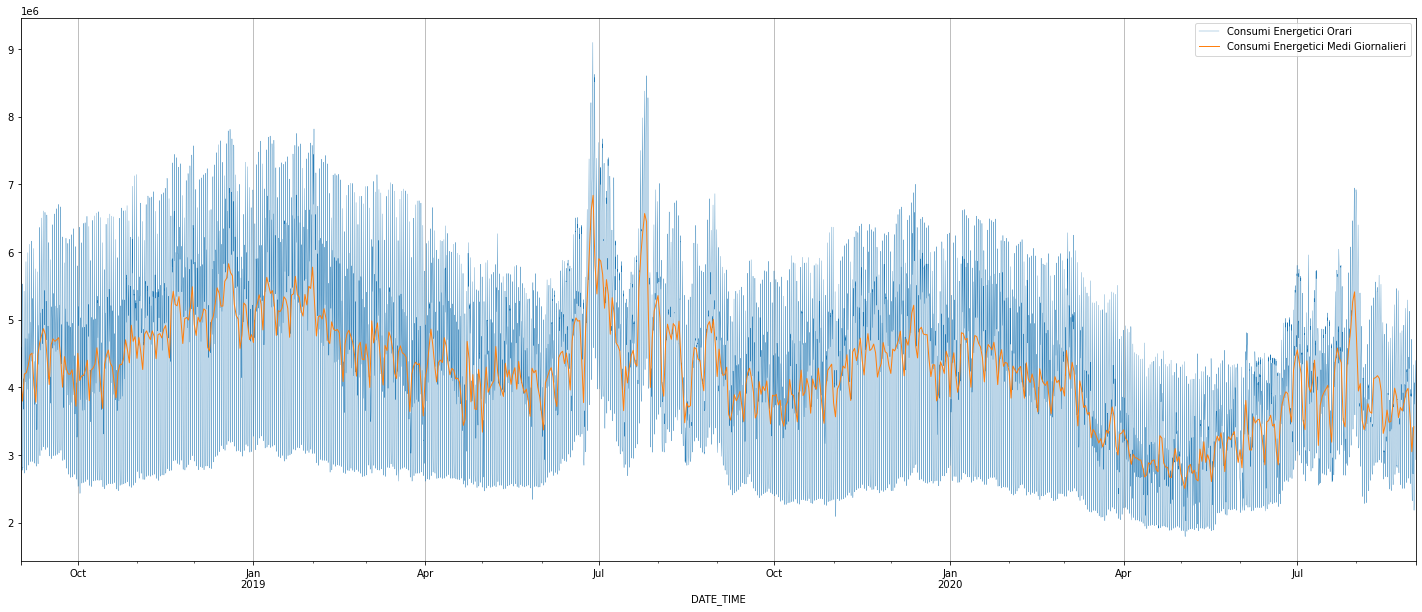

In [8]:
dates = df_24.index._mpl_repr()
ax = df_24['Y'].plot(figsize=(25,6) , linewidth = 0.3, label = 'Consumi Energetici Orari', legend = True)
df_24.resample('d').mean()['Y'].plot(figsize=(25,10) , linewidth = 1, label = 'Consumi Energetici Medi Giornalieri', legend = True)
ylim = ax.get_ylim()
ax.xaxis.grid()

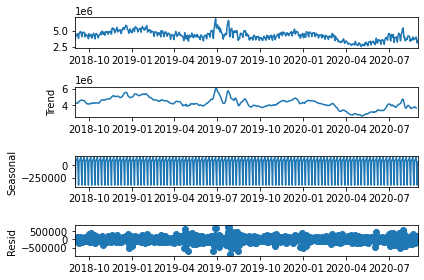

In [9]:
# ETS Decomposition
df_11 = df_24[['Y']].resample('d').mean()
df_11.index.freq = 'd'
result = seasonal_decompose(df_11, model='add')
result.plot();

In [10]:
dta = df_24.resample('d').mean()
dta

Y  Hour
DATE_TIME                     
2018-09-01  4.128740e+06  11.5
2018-09-02  3.799029e+06  11.5
2018-09-03  4.197913e+06  11.5
2018-09-04  4.217695e+06  11.5
2018-09-05  4.324142e+06  11.5
...                  ...   ...
2020-08-27  3.938025e+06  11.5
2020-08-28  3.987303e+06  11.5
2020-08-29  3.591072e+06  11.5
2020-08-30  3.050869e+06  11.5
2020-08-31  3.420317e+06  11.5

[731 rows x 2 columns]

In [11]:
def adf_test(series,title=f'CONSUMI ENERGETICI'):
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [12]:
adf_test(dta['Y'])

Augmented Dickey-Fuller Test: CONSUMI ENERGETICI
ADF test statistic       -1.506152
p-value                   0.530466
# lags used              19.000000
# observations          711.000000
critical value (1%)      -3.439581
critical value (5%)      -2.865614
critical value (10%)     -2.568939
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


In [13]:
help(sm.tsa.UnobservedComponents)

Help on class UnobservedComponents in module statsmodels.tsa.statespace.structural:

class UnobservedComponents(statsmodels.tsa.statespace.mlemodel.MLEModel)
 |  UnobservedComponents(endog, level=False, trend=False, seasonal=None, freq_seasonal=None, cycle=False, autoregressive=None, exog=None, irregular=False, stochastic_level=False, stochastic_trend=False, stochastic_seasonal=True, stochastic_freq_seasonal=None, stochastic_cycle=False, damped_cycle=False, cycle_period_bounds=None, mle_regression=True, use_exact_diffuse=False, **kwargs)
 |  
 |  Univariate unobserved components time series model
 |  
 |  These are also known as structural time series models, and decompose a
 |  (univariate) time series into trend, seasonal, cyclical, and irregular
 |  components.
 |  
 |  Parameters
 |  ----------
 |  
 |  level : {bool, str}, optional
 |      Whether or not to include a level component. Default is False. Can also
 |      be a string specification of the level / trend component; see N

In [14]:
unrestricted_model = {
    'irregular': True,
    'level': True,
    'stochastic_level': True,
    'trend': False,
    'cycle': True,
    'stochastic_cycle': True,
    'cycle_period_bounds' : (180,185),
    'seasonal' : 7
}



In [15]:
output_mod = sm.tsa.UnobservedComponents(dta['Y'], **unrestricted_model)
output_res = output_mod.fit( disp=False)

In [16]:
print(output_res.summary())

                           Unobserved Components Results                            
Dep. Variable:                            Y   No. Observations:                  731
Model:                          local level   Log Likelihood              -10771.035
                   + stochastic seasonal(7)   AIC                          21552.071
                         + stochastic cycle   BIC                          21574.981
Date:                      Tue, 01 Jun 2021   HQIC                         21560.914
Time:                              12:34:54                                         
Sample:                          09-01-2018                                         
                               - 08-31-2020                                         
Covariance Type:                        opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------

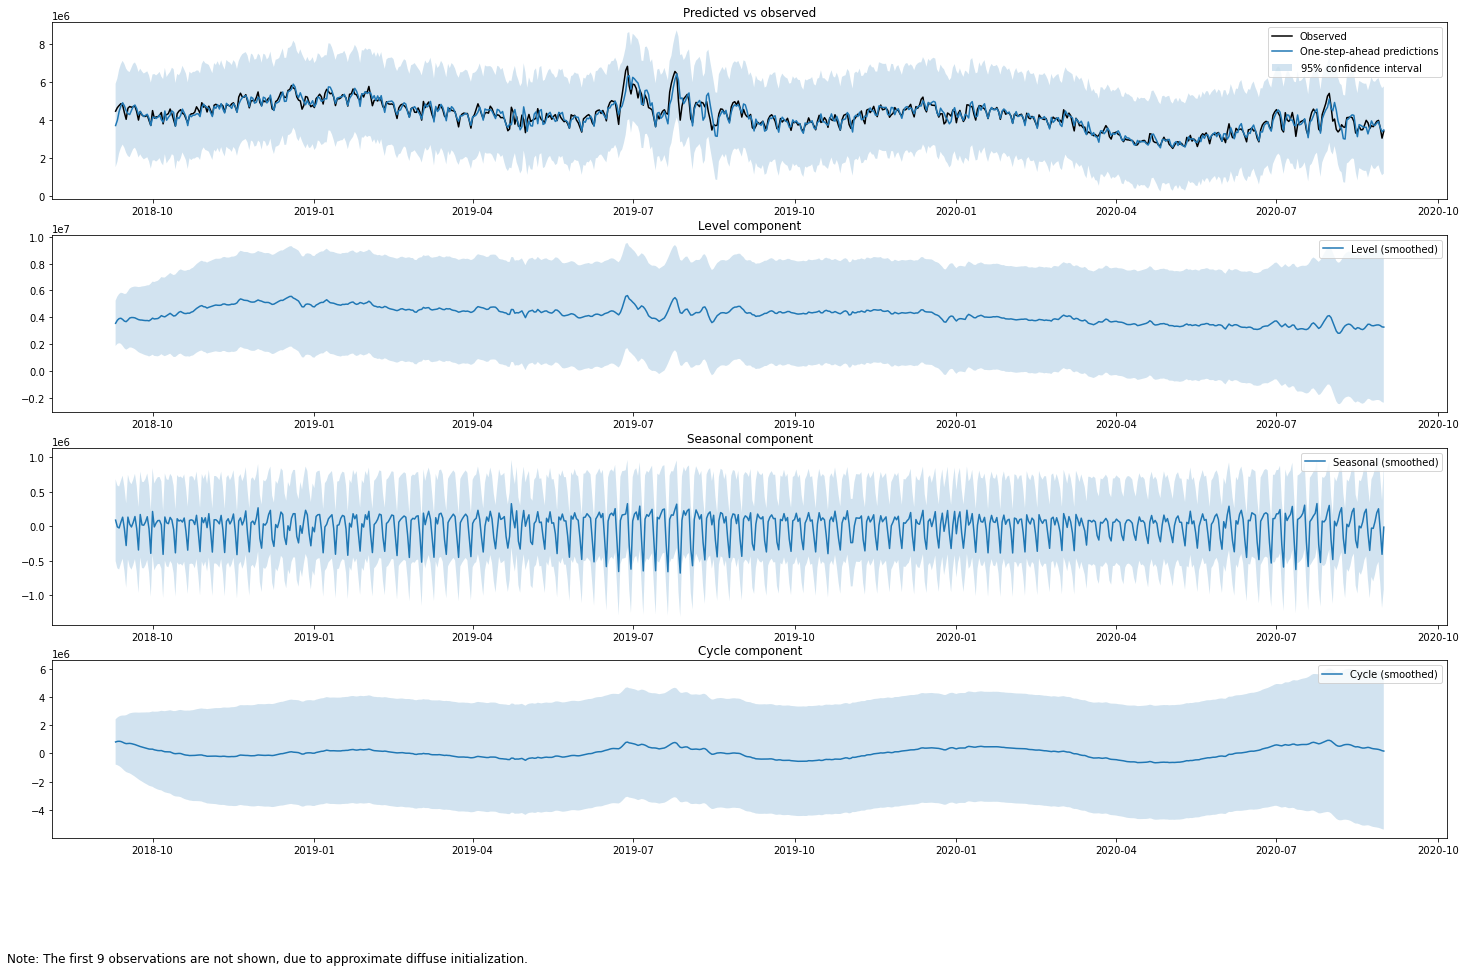

In [17]:
fig = output_res.plot_components(legend_loc='upper right', figsize=(25, 15));

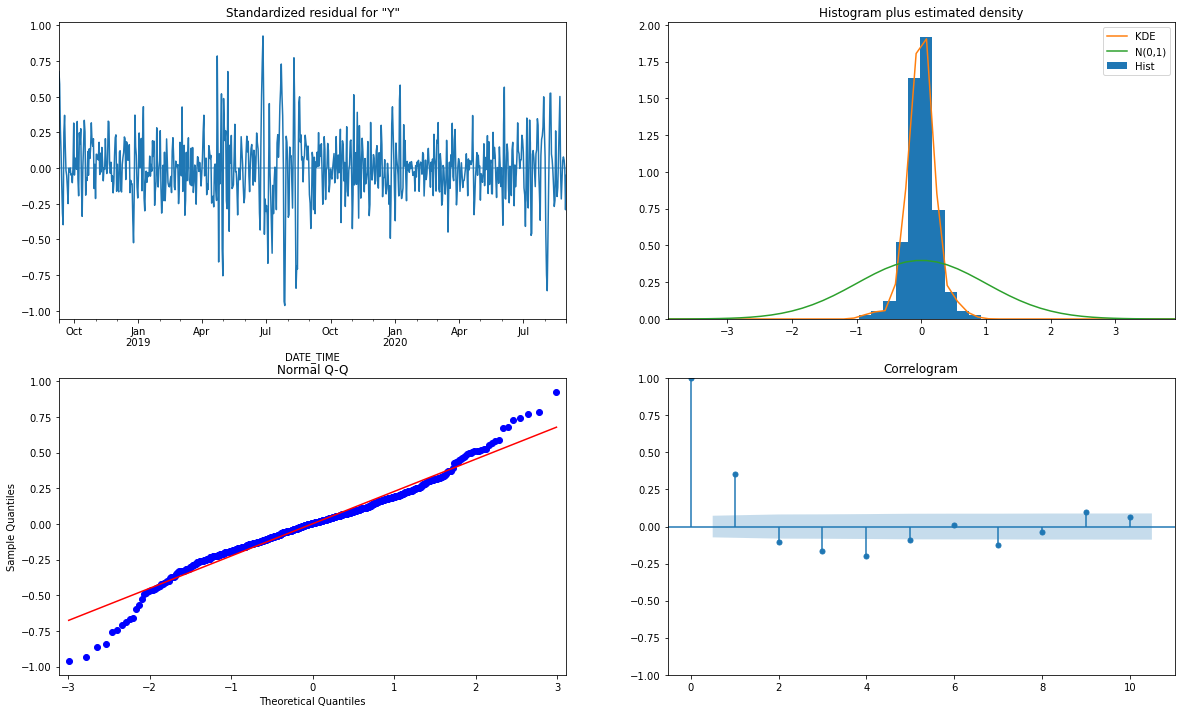

In [18]:
output_res.plot_diagnostics(figsize=(20, 12))
plt.show()

In [19]:
fcast = output_res.predict(start = '2020-09-01', end = '2020-10-31' ).rename(f'UCM')

In [20]:
fcast

2020-09-01    3.386984e+06
2020-09-02    3.456282e+06
2020-09-03    3.558606e+06
2020-09-04    3.592809e+06
2020-09-05    3.253917e+06
                  ...     
2020-10-27    2.508023e+06
2020-10-28    2.606000e+06
2020-10-29    2.737985e+06
2020-10-30    2.802794e+06
2020-10-31    2.495421e+06
Freq: D, Name: UCM, Length: 61, dtype: float64

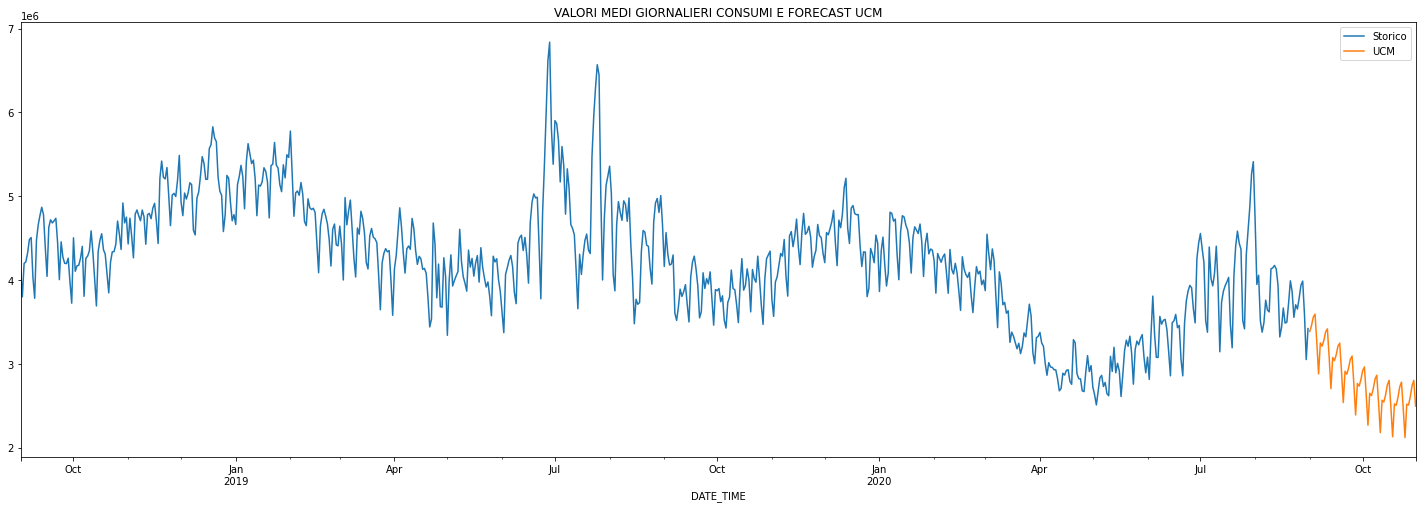

In [21]:
title=f'VALORI MEDI GIORNALIERI CONSUMI E FORECAST UCM'
ylabel='MW'
xlabel=''
dta['Y'].plot(legend=True, label ='Storico')
fcast.plot(legend=True,figsize=(25,8),title=title, label ='UCM');

## UCM hh24

In [22]:
mySeries = []
namesofMySeries = []
list_df = [pd.DataFrame() for x in range(24)]
list_hour = list(range(24))
for i in list_hour:
    df_h = df_24[df_24.index.hour == i][['Y']]
    df_h.index = df_h.index.date
    list_df[i] = df_h
    mySeries.append(list_df[i])
    namesofMySeries.append(list_hour[i])

In [23]:
list_hour = list(range(24))
SeriesFor = [[] for x in range(24)]
namesofMySeriesFor = []
for i in list_hour:
    
    df_h = df_24[df_24.index.hour == i]

    output_mod = sm.tsa.UnobservedComponents(df_h['Y'], **unrestricted_model)
    output_res = output_mod.fit( disp=False)

    print(output_res.summary())

    SeriesFor[i] = output_res.predict(start = '2020-09-01', end = '2020-10-31' ).rename(f'UCM')
    #SeriesFor.append(SeriesFor[i])
    namesofMySeriesFor.append(list_hour[i])
    print('======== Forecast ========')
    print()
    print(SeriesFor[i])

                           Unobserved Components Results                            
Dep. Variable:                            Y   No. Observations:                  731
Model:                          local level   Log Likelihood              -10554.837
                   + stochastic seasonal(7)   AIC                          21119.673
                         + stochastic cycle   BIC                          21142.583
Date:                      Tue, 01 Jun 2021   HQIC                         21128.517
Time:                              12:34:59                                         
Sample:                          09-01-2018                                         
                               - 08-31-2020                                         
Covariance Type:                        opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------

In [24]:
l = []
sdate = date(2020, 9, 1) 
edate = date(2020, 10, 31) 
delta = edate - sdate       
for i in range(delta.days + 1):
    day = sdate + timedelta(days=i)
    l.append(day)

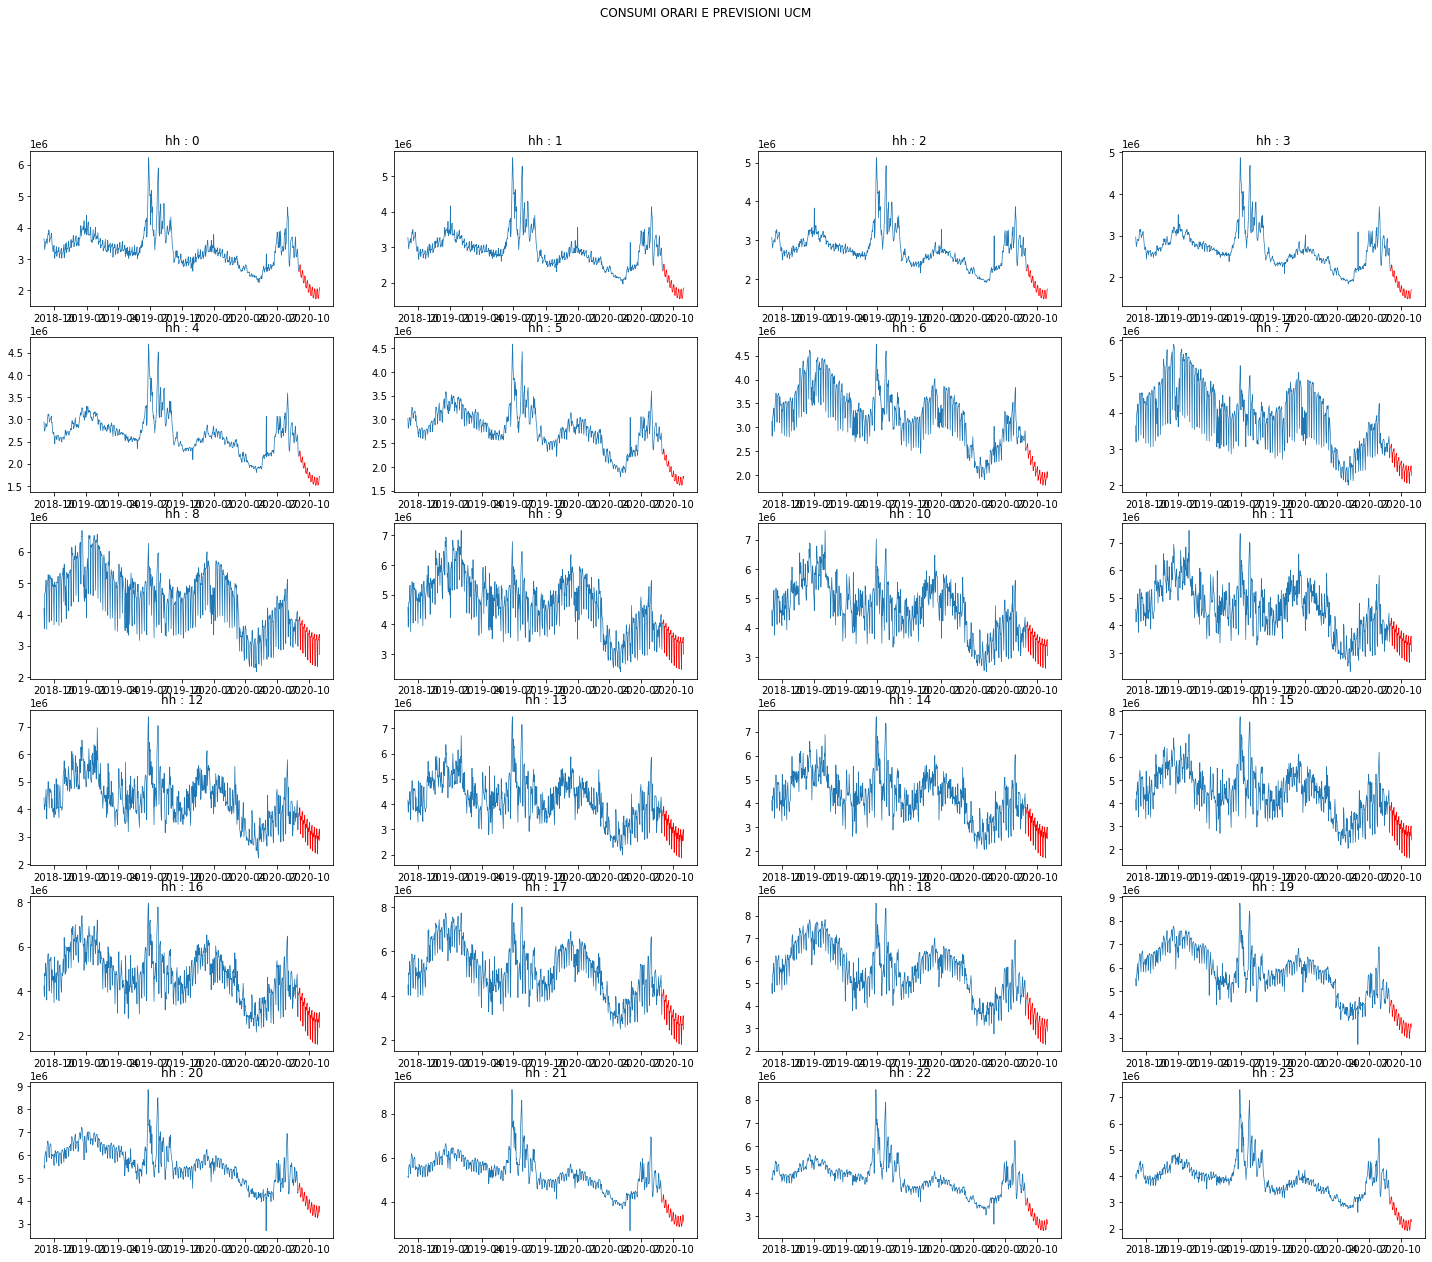

In [25]:
fig, axs = plt.subplots(6,4,figsize=(25,20))
fig.suptitle('CONSUMI ORARI E PREVISIONI UCM')
for i in range(6):
    for j in range(4):
        if i*4+j+1>len(SeriesFor):
            continue
        axs[i, j].plot(mySeries[i*4+j]['Y'], linewidth = 0.7)
        axs[i, j].plot((SeriesFor[i*4+j]), color = 'r', linewidth = 0.7)
        axs[i, j].set_title('hh : ' + str(namesofMySeriesFor[i*4+j]))
plt.show()

In [26]:
mySeriesComp = []
namesofMySeries = []

for i in list_hour:
    df_h = df_24[df_24.index.hour == i][['Y']]
    df_h.index = df_h.index.date
    list_df[i] = df_h
    mySeries.append(list_df[i])
    namesofMySeries.append(list_hour[i])

In [27]:
mySeriesComp = [pd.DataFrame() for x in range(24)]
for i in list_hour:
    dfFor = pd.DataFrame(SeriesFor[i])
    dfFor.index = dfFor.index.date
    dfFor.columns = ['Y']
    mySeriesComp[i] = pd.concat([mySeries[i], dfFor], axis=0)

In [28]:
lista = []
for i in range(len(mySeriesComp[0])):
    for j in list_hour:
        lista.append(float(mySeriesComp[j].iloc[i]))

In [29]:
dfcompleto = pd.DataFrame(lista)

In [30]:
df_cal_comp = pd.DataFrame(
        {'DATE_TIME': pd.date_range('2018-09-01', '2020-11-01', freq='1H', closed='left')}
     )

In [31]:
dfcompleto1 = pd.concat([df_cal_comp, dfcompleto], axis=1)

In [32]:
dfcompleto1 = dfcompleto1.set_index('DATE_TIME')
dfcompleto1.columns = ['Y']
dfcompleto1["DATA"] = dfcompleto1.index.date
dfcompleto1["Ora"] = dfcompleto1.index.hour
dfcompleto1["Ora"] = dfcompleto1["Ora"].astype(int)

dfcompleto1 = dfcompleto1[['DATA', 'Ora', 'Y']]

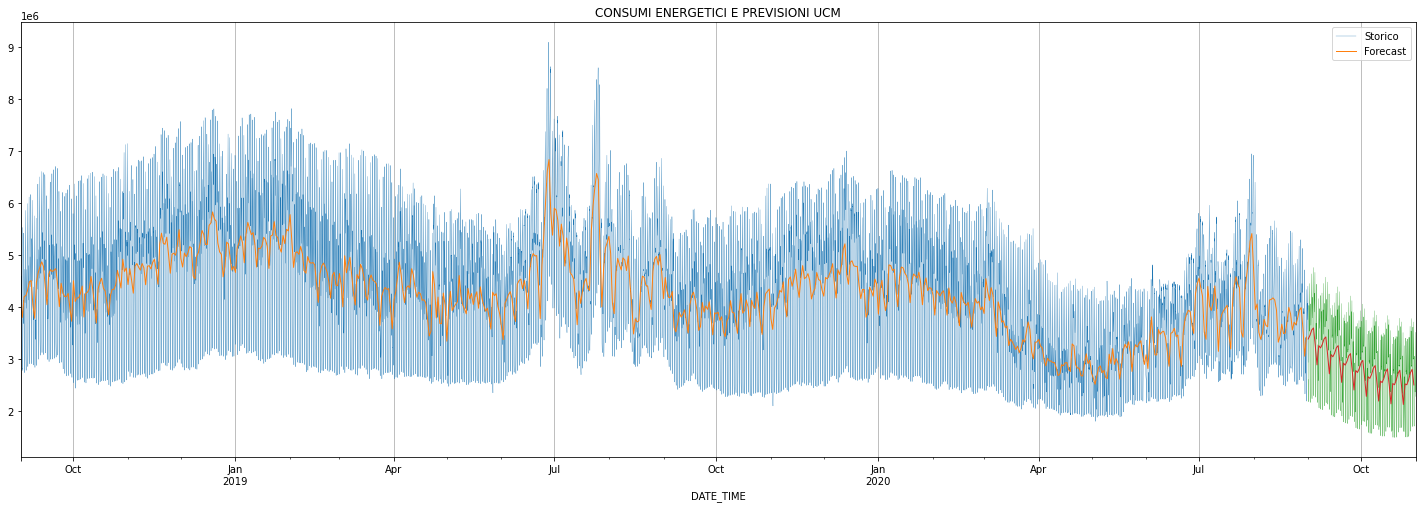

In [33]:
title=f'CONSUMI ENERGETICI E PREVISIONI UCM'
ax = dfcompleto1.loc[:'2020-08-31'] ['Y'].plot(legend=True, label = 'Storico',figsize=(25,8),title=title , linewidth =0.3)
dfcompleto1.loc[:'2020-08-31'].resample('d').mean() ['Y'].plot(legend=False,figsize=(25,8),title=title , linewidth =1)
dfcompleto1.loc['2020-09-01':]['Y'].plot(legend=True, label = 'Forecast', linewidth =0.3)
dfcompleto1.loc['2020-09-01':].resample('d').mean()['Y'].plot(legend=False, label = 'Forecast', linewidth =1)
ax.xaxis.grid();

In [34]:
dfcompletofor = dfcompleto1.copy()

dfcompletofor["Ora"] = dfcompletofor["Ora"].astype(int)
dfcompletofor["Ora"] = dfcompletofor["Ora"] +1
dfcompletofor.columns = ['Data', 'Ora', 'UCM']

In [35]:
dfcompletofor

Data  Ora           UCM
DATE_TIME                                         
2018-09-01 00:00:00  2018-09-01    1  3.646742e+06
2018-09-01 01:00:00  2018-09-01    2  3.273110e+06
2018-09-01 02:00:00  2018-09-01    3  3.069245e+06
2018-09-01 03:00:00  2018-09-01    4  2.969621e+06
2018-09-01 04:00:00  2018-09-01    5  2.944116e+06
...                         ...  ...           ...
2020-10-31 19:00:00  2020-10-31   20  3.454743e+06
2020-10-31 20:00:00  2020-10-31   21  3.512030e+06
2020-10-31 21:00:00  2020-10-31   22  3.101369e+06
2020-10-31 22:00:00  2020-10-31   23  2.654569e+06
2020-10-31 23:00:00  2020-10-31   24  2.275279e+06

[19008 rows x 3 columns]

In [36]:
os.getcwd()

'C:\\Users\\gianluca.simionato\\Desktop\\DS\\StreamingDataManagement_TimeSeriesAnalysis\\PROJECT\\OUTPUT'

In [37]:
dfcompletofor.to_csv('UCM.csv', sep=';', decimal=',', index = False)